In [51]:
# !pip install -U langgraph langsmith
# !pip install -U "langchain[openai]"

In [ ]:
import os 
from dotenv import load_dotenv
import requests
from datetime import datetime, timedelta
import json
from langchain_core.tools import tool


@tool("TravelportSearch")
def TravelportSearch(departure_date:str, from_city:str, to_city:str, carrier:str):

    """This tool calls the travelport rest api to get teh cheapest flight possible for the user's given parameters"""
    load_dotenv()  # Reads .env in current directory

    CLIENT_ID       = os.getenv("TRAVELPORT_CLIENT_ID")
    CLIENT_SECRET   = os.getenv("TRAVELPORT_CLIENT_SECRET")
    USERNAME        = os.getenv("TRAVELPORT_USERNAME")
    PASSWORD        = os.getenv("TRAVELPORT_PASSWORD")
    ACCESS_GROUP    = os.getenv("TRAVELPORT_ACCESS_GROUP")

    OAUTH_URL       = "https://oauth.pp.travelport.com/oauth/oauth20/token"
    CATALOG_URL     = "https://api.pp.travelport.com/11/air/catalog/search/catalogproductofferings"
    AIRPRICE_URL     = "https://api.pp.travelport.com/11/air/price/offers/buildfromcatalogproductofferings"

    def fetch_password_token():
        data = {
            "grant_type":    "password",
            "username":      USERNAME,
            "password":      PASSWORD,
            "client_id":     CLIENT_ID,
            "client_secret": CLIENT_SECRET,
            "scope":         "openid"
        }
        resp = requests.post(
            OAUTH_URL,
            headers={"Content-Type": "application/x-www-form-urlencoded"},
            data=data
        )
        resp.raise_for_status()
        return resp.json()["access_token"]

    token = fetch_password_token()
    # print(f"🔑 Token obtained: {token[:20]}…")

    headers = {
    "Accept":                       "application/json",
    "Content-Type":                 "application/json",
    "Accept-Encoding":              "gzip, deflate",
    "Cache-Control":                "no-cache",
    "Authorization":                f"Bearer {token}",
    "XAUTH_TRAVELPORT_ACCESSGROUP": ACCESS_GROUP,
    "Accept-Version":               "11",
    "Content-Version":              "11",
    }
    # print("📋 Headers built")

    carrier_list = [carrier]

    # Now build the payload using those real date strings:
    payload = {
        "@type": "CatalogProductOfferingsQueryRequest",
        "CatalogProductOfferingsRequest": {
            "@type": "CatalogProductOfferingsRequestAir",
            "maxNumberOfUpsellsToReturn": 1,
            "contentSourceList": ["GDS"],
            "PassengerCriteria": [
                {
                    "@type": "PassengerCriteria",
                    "number": 1,
                    "age": 25,
                    "passengerTypeCode": "ADT"
                }
            ],
            "SearchCriteriaFlight": [
                {
                    "@type": "SearchCriteriaFlight",
                    "departureDate": departure_date,   # injected here
                    "From": {"value": from_city},
                    "To":   {"value": to_city}
                },
                
            ],
            "SearchModifiersAir": {
                "@type": "SearchModifiersAir",
                "CarrierPreference": [
                    {
                        "@type": "CarrierPreference",
                        "preferenceType": "Preferred",
                        "carriers": carrier_list
                    }
                ]
            },
            "CustomResponseModifiersAir": {
                "@type": "CustomResponseModifiersAir",
                "SearchRepresentation": "Journey"
            }
        }
    }

    response = requests.post(CATALOG_URL, headers=headers, json=payload)
    try:
        response.raise_for_status()
        result = response.json()
        import json
        # print(json.dumps(result, indent=2))
    except requests.HTTPError as e:
        print("❌ Request failed:", e)
        print(response.status_code, response.text)

    cheapest_flight_price = result["CatalogProductOfferingsResponse"]["CatalogProductOfferings"]["CatalogProductOffering"][0]["ProductBrandOptions"][0]["ProductBrandOffering"][0]["BestCombinablePrice"]["TotalPrice"]

    return cheapest_flight_price


In [ ]:
@tool("UserInputParser")
def UserInputParser(user_input:str):

In [53]:
from langchain_core.tools import tool as lc_tool

# If already decorated above, TravelportSearch has .invoke; else wrap it
tool = TravelportSearch if hasattr(TravelportSearch, "invoke") else lc_tool("TravelportSearch")(TravelportSearch)
tools = [tool]

In [54]:
import os
from langchain.chat_models import init_chat_model

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") 

llm = init_chat_model("gpt-4o-mini", model_provider="openai", temperature=0)

In [55]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[dict], add_messages]

graph_b = StateGraph(State)

llm_with_tools= llm.bind_tools(tools)

In [56]:
def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_b.add_node("chatbot", chatbot)

In [57]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """Node that runs the tools requested in the last AI message."""

    def __init__(self, tools: list)-> None:
        self.tools_by_name = {tool.name:tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages in inputs")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    

tool_node = BasicToolNode(tools=[tool])

graph_b.add_node("tools", tool_node)

In [58]:
def route_tools(
    state: State,
):

    """
        Use in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages:=state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("No messages in state", {state})
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END
    
    

In [59]:
graph_b.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_b.add_edge("tools", "chatbot")
graph_b.add_edge(START, "chatbot")
graph = graph_b.compile()

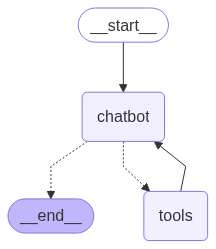

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [61]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [62]:
graph = graph_b.compile(checkpointer=memory)

In [63]:
config = {"configurable": {"thread_id": "1"}}

In [64]:
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="updates",
    )
    for update in events:
        for _node, payload in update.items():
            if isinstance(payload, dict) and "messages" in payload:
                msgs = payload["messages"]
                if not msgs:
                    continue
                last = msgs[-1]
                try:
                    last.pretty_print()
                except Exception:
                    print(getattr(last, "content", str(last)))
        

In [65]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["exit", "quit", "bye", "q"]:
            break
        stream_graph_updates(user_input)
    except:
        user_input = input("User: ")
        stream_graph_updates(user_input)
        break

================================== Ai Message ==================================

Hello! How can I assist you today?
================================== Ai Message ==================================

Great! Are you looking for information or assistance related to travel, activities, or something else in London?
================================== Ai Message ==================================

Got it! You're referring to London Heathrow Airport (LHR). How can I assist you with that? Are you looking for flights, transportation, or something else?
================================== Ai Message ==================================
Tool Calls:
  TravelportSearch (call_guX22V5ifvu5l8LAp5CmgIL7)
 Call ID: call_guX22V5ifvu5l8LAp5CmgIL7
  Args:
    departure_date: 2025-11-24
    from_city: LHR
    to_city: LIN
    carrier: QR


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_guX22V5ifvu5l8LAp5CmgIL7", 'type': 'invalid_request_error', 'param': 'messages.[8].role', 'code': None}}

In [66]:
!pip install assemblyai 

   ---------------------------------------- 0.0/50.1 kB ? eta -:--:--
   ---------------------------------------- 50.1/50.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Install the assemblyai package by executing the command "pip install assemblyai"

import assemblyai as aai

aai.settings.api_key = 

# audio_file = "./local_file.mp3"
audio_file = "https://assembly.ai/wildfires.mp3"

config = aai.TranscriptionConfig(speech_model=aai.SpeechModel.best)

transcript = aai.Transcriber(config=config).transcribe(audio_file)

if transcript.status == "error":
  raise RuntimeError(f"Transcription failed: {transcript.error}")

print(transcript.text)

Smoke from hundreds of wildfires in Canada is triggering air quality alerts throughout the US Skylines from Maine to Maryland to Minnesota are gray and smoggy. And in some places, the air quality warnings include the warning to stay inside. We wanted to better understand what's happening here and why, so we called Peter DeCarlo, an associate professor in the Department of Environmental Health and Engineering at Johns Hopkins University. Good morning, Professor. Good morning. So what is it about the conditions right now that have caused this round of wildfires to affect so many people so far away? Well, there's a couple of things. The season has been pretty dry already, and then the fact that we're getting hit in the US is because there's a couple weather systems that are essentially channeling the smoke from those Canadian wildfires through Pennsylvania into the mid Atlantic and the Northeast and kind of just dropping the smoke there. So what is it in this haze that makes it harmful? A